<a href="https://colab.research.google.com/github/Carvas91/PyTroch/blob/main/dropout_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

<ipython-input-1-d72e685802b3>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
nPerClust = 200

th = np.linspace(0,4*np.pi, nPerClust)
r1 = 10
r2 = 15

a = [r1*np.cos(th) + np.random.randn(nPerClust)*3,
     r1*np.sin(th) + np.random.randn(nPerClust)]

b = [r2*np.cos(th) + np.random.randn(nPerClust)*3,
     r2*np.sin(th) + np.random.randn(nPerClust)]

labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

data_np = np.hstack((a,b)).T

data = torch.tensor(data_np).float()

labels = torch.tensor(labels_np).float()

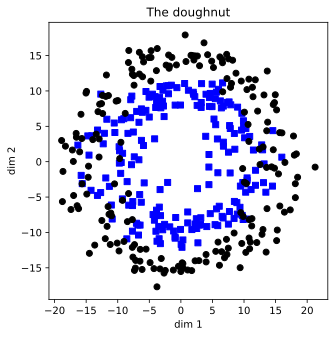

In [3]:
plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],
         data[np.where(labels==0)[0],1],'bs')

plt.plot(data[np.where(labels==1)[0],0],
         data[np.where(labels==1)[0],1],'ko')

plt.title('The doughnut')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchsize = 16 #int(train_data.tensors[0].shape[0]/4])
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])




In [5]:
class theModelClass(nn.Module):
  def __init__(self, dropoutRate):
    super().__init__()

    self.input = nn.Linear(2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128,1)

    self.dr = dropoutRate

  def forward(self,x):
    x = F.relu(self.input(x))
    x = F.dropout(x,p=self.dr, training=self.training)

    x = F.relu(self.hidden(x))
    x = F.dropout(x, p=self.dr, training=self.training)

    x = self.output(x)
    return x



In [6]:
def createModel(dropoutrate):
  ANN = theModelClass(0.25)

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.SGD(ANN.parameters(), lr=0.02)

  return ANN, lossfun, optimizer

In [7]:
epochs = 1000

def trainModel(ANN, lossfun, optimizer):
    trainACC = []
    testAcc = []

    for i in range(epochs):
        batchAcc = []

        ANN.train()  # set model to training mode
        for X, y in train_loader:
            yHat = ANN(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(torch.mean(((yHat > 0.5) == y).float()).item() * 100)

        trainACC.append(np.mean(batchAcc))

        ANN.eval()  # set model to evaluation mode
        batchTestAcc = []

        with torch.no_grad():
            for X, y in test_loader:
                yHat = ANN(X)
                batchTestAcc.append(torch.mean(((yHat > 0.5) == y).float()).item() * 100)

        testAcc.append(np.mean(batchTestAcc))

    return trainACC, testAcc

In [8]:
dr = 0
ANN, lossfun, optimizer = createModel(dropoutrate=dr)

trainAcc, testAcc = trainModel(ANN, lossfun, optimizer)

In [9]:
def smooth(x, k=5):
  return np.convolve(x,np.ones(k)/k, mode='same')

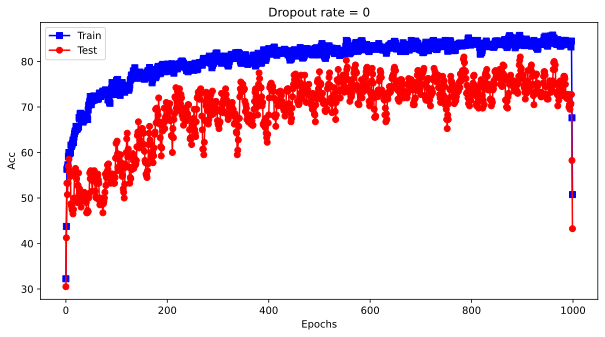

In [10]:
plt.figure(figsize=(10,5))
plt.plot(smooth(trainAcc), 'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['Train', 'Test'])
plt.title('Dropout rate = %g' %dr)
plt.show()

In [13]:
doRates = np.arange(10)/10
results = np.zeros((len(doRates),2))

for i in range(len(doRates)):
  ANN,lossfun, optimizer = createModel(doRates[i])
  trainAcc,testAcc = trainModel(ANN, lossfun, optimizer)

  results[i,0] =np.mean(trainAcc[-100:])
  results[i,1] = np.mean(testAcc[-100:])



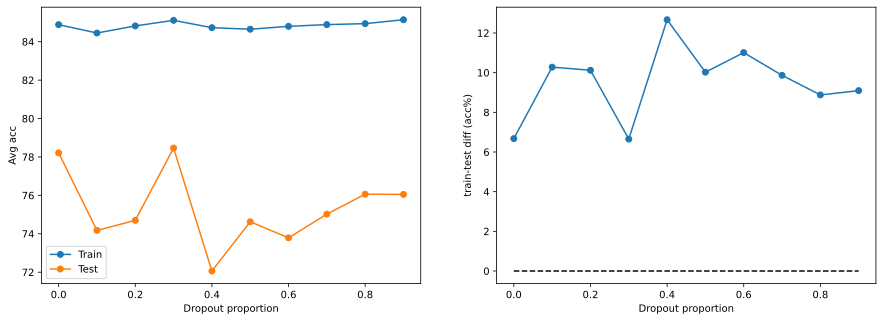

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(doRates, results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Avg acc')
ax[0].legend(['Train','Test'])

ax[1].plot(doRates, -np.diff(results, axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('train-test diff (acc%)')

plt.show()